In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import pickle
import random
import os
import pandas as pd
import re
pd.set_option('display.max_colwidth', None)

In [2]:
train = pd.read_pickle('C:\\Users\\galin\\PycharmProjects\\aiAssignment\\data\\train_data_clean.pkl')
round(train['label'].value_counts()/len(train)*100,2)

0    79.71
1    20.29
Name: label, dtype: float64

In [3]:
test = pd.read_pickle('C:\\Users\\galin\\PycharmProjects\\aiAssignment\\data\\test_data_clean.pkl')
round(test['label'].value_counts()/len(test)*100,2)

0    79.71
1    20.29
Name: label, dtype: float64

In [4]:
maxSequenceLength_train = train['clean_paragraph_len'].max()#121 
maxSequenceLength_test = test['clean_paragraph_len'].max() 

In [5]:
#Sentences array for train and test sets + target variable for train and test
text_train = train['remove_stop_words']
y_train = train['label']

text_test = test['remove_stop_words']
y_test = test['label']


In [6]:
#vocab_size count
results = set()
train.remove_stop_words.str.split().apply(results.update)
vocab_size = len(results)
vocab_size

2190

In [7]:
maxSequenceLength_train = train['clean_paragraph_len'].max()#121 91-seed 42
maxSequenceLength_test = test['clean_paragraph_len'].max() #86 91-seed 42
maxSequenceLength_test, maxSequenceLength_train #(81, 91),

(81, 121)

In [8]:
def sent2vec(texts, max_sequence_length):
    """ Create a union train set vocabulary and turn text in set
    into  padded sequences (word --> num )
    :param texts: series of prepared strings
           max_sequence_length: int max len of sentence in series
    :return ndArray with transformed series of text to int
            with 0-padding up to max_sequence_length"""
        
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(texts)
#     print('vocab len',vocab_size,len(tokenizer.word_index))
    
    # Turn text into  padded sequences (word --> num )
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen=max_sequence_length,
                         dtype="int32", padding="post", value=0)

In [9]:
#for train nlp
sent2vec_train = sent2vec(text_train, maxSequenceLength_train)

# index_max_len_sent = train[train['clean_paragraph_len'] == maxSequenceLength_train].index 
# sent2vec_train[index_max_len_sent]
X_meta_train = train[['sent_count','num_count','clean_paragraph_len','contains_pron']]
# sent2vec_train.shape, X_meta_train.shape

embedding_dimensions = 256 #128
embedding_dimensions

256

In [10]:
#for test nlp
sent2vec_test = sent2vec(text_test, maxSequenceLength_train)

# index_max_len_sent = train[train['clean_paragraph_len'] == maxSequenceLength_train].index 
# sent2vec_train[index_max_len_sent]
X_meta_test = test[['sent_count','num_count','clean_paragraph_len','contains_pron']]
sent2vec_test.shape, X_meta_test.shape

((1454, 121), (1454, 4))

In [11]:
def get_model(sent2vec_train,X_meta_train, results,embedding_dimensions=int(len(results)**0.25)):
    
    nlp_input = Input(shape=(sent2vec_train.shape[1],)) 

    meta_input = Input(shape=(X_meta_train.shape[1],))

    emb = Embedding(output_dim=embedding_dimensions, 
                    input_dim=len(results) + 1, 
                    input_length=sent2vec_train.shape[1],
                    mask_zero=True)(nlp_input)  # Use masking to handle the variable sequence lengths

    nlp_out = Bidirectional(LSTM(128))(emb) 

    concat = tf.concat([nlp_out, meta_input], axis=1) 

    classifier = Dense(32, activation='relu')(concat) 

    drop = Dropout(0.5)(classifier) #0.2

    output = Dense(1, activation='sigmoid')(drop) 

    model = Model(inputs=[nlp_input , meta_input], outputs=[output])

    
    return model

In [12]:
concat_biLstm = get_model(sent2vec_train,X_meta_train, results,embedding_dimensions)

In [13]:
concat_biLstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 121)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 121, 256)     560896      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
______________________________________________________________________________________________

In [14]:
concat_biLstm.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [15]:
SEQ_LEN=121 # max len sequence
EMBEDDING_SIZE=121
BATCH_SIZE= 256#64 loss: 0.2981 - accuracy: 0.9498 #256 --> acc0.95 loss0.24, 128-->acc94 loss 0.26 with dropout 0.5
EPOCHS=200
THRESHOLD=0.5



es = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
          , mode='min')
callbacks=[es]
history = concat_biLstm.fit([sent2vec_train,X_meta_train], y_train
                    , batch_size=BATCH_SIZE
                    , epochs=EPOCHS
                    , validation_split=0.2
                    , callbacks=callbacks)

Epoch 1/200
11/11 [==============================] - 26s 2s/step - loss: 1.5465 - accuracy: 0.4214 - val_loss: 0.5458 - val_accuracy: 0.8041
Epoch 2/200
11/11 [==============================] - 16s 1s/step - loss: 0.4812 - accuracy: 0.8320 - val_loss: 0.0600 - val_accuracy: 0.9956
Epoch 3/200
11/11 [==============================] - 18s 2s/step - loss: 0.0953 - accuracy: 0.9722 - val_loss: 0.0218 - val_accuracy: 0.9912
Epoch 4/200
11/11 [==============================] - 18s 2s/step - loss: 0.0345 - accuracy: 0.9944 - val_loss: 0.0341 - val_accuracy: 0.9897


In [16]:
score = concat_biLstm.evaluate([sent2vec_test,X_meta_test], y_test,
                       batch_size=BATCH_SIZE, verbose=1)
print()
print(u'Model Loss score: {}'.format(score[0]))
print(u'Model Accuracy Evaluation : {}'.format(score[1]))


6/6 [==============================] - 2s 374ms/step - loss: 0.1075 - accuracy: 0.9677

Model Loss score: 0.10745111107826233
Model Accuracy Evaluation : 0.9676753878593445


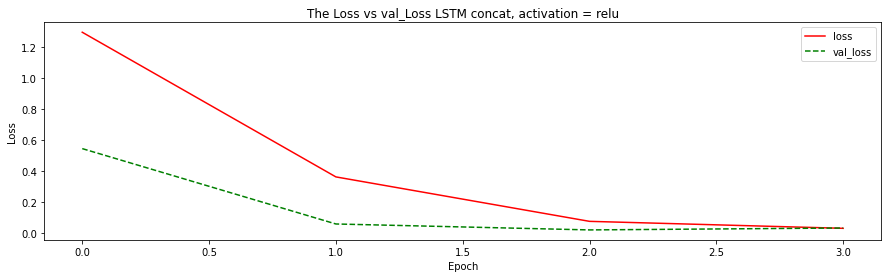

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'],'r', label='loss')
plt.plot(history.history['val_loss'],'g--', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 0.5])
# plt.xlim([0, 20])
plt.title('The Loss vs val_Loss LSTM concat, activation = relu')
plt.legend(loc='best');

In [21]:
DATA_FILE = 'concat_biLstm.pkl'
def check_dir_path(filename, what_to_do):
    """The function receive filename:txt
    checks is the path exists and creates empty file
    :return file and path"""
    path = ''
    if not os.path.exists('{}/data'.format(os.getcwd())):
        os.makedirs('{}/data'.format(os.getcwd()))
    try:
        path = '{}/data/{}'.format(os.getcwd(), filename)
        file = open(path, what_to_do)
    except:
        raise Exception('WTF!!!! Could not open {}'.format(path))
    return file, path  # DON'T FORGET TO CLOSE `file` IN THE PLACE WHERE YOU CALL THIS FUNCTION


def save_data_to_pkl(data_file, file_name=DATA_FILE):
    """The function receive  a data_file:obj
    checks the path and dumps into the pkl file
    :return full path of saved data_file:str"""

    file, path = check_dir_path(file_name, 'wb')
    pickle.dump(data_file, file, pickle.HIGHEST_PROTOCOL)
    file.close()
    return path

### Saving/restoring the model

In [23]:
concat_biLstm.save('my_model.h5')

In [24]:
new_model = tf.keras.models.load_model('my_model.h5')

In [26]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 121)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 121, 256)     560896      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
______________________________________________________________________________________________